In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1. Load the dataset
data = pd.read_csv('/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned_sensor_data.csv')

# Check if the first row contains indexes and adjust accordingly
if data.iloc[0, 0] == '0' and 'timestamp' not in data.columns:
    # Create column names based on the sample provided
    column_names = ['index', 'timestamp']
    column_names.extend([f'sensor_{i:02d}' for i in range(52)])
    column_names.append('machine_status')

    # Load the data again with proper column names
    data = pd.read_csv('your_dataset.csv', names=column_names)

    # Drop the index column if it exists
    if 'index' in data.columns:
        data = data.drop('index', axis=1)

# Display dataset info
print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (220320, 54)
             timestamp  Unnamed: 0  sensor_00  sensor_01  sensor_02  \
0  2018-04-01 00:00:00         0.0   2.465394   47.09201    53.2118   
1  2018-04-01 00:01:00         1.0   2.465394   47.09201    53.2118   
2  2018-04-01 00:02:00         2.0   2.444734   47.35243    53.2118   
3  2018-04-01 00:03:00         3.0   2.460474   47.09201    53.1684   
4  2018-04-01 00:04:00         4.0   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Handle missing values
# Note that sensor_15 has a very high number of missing values (220320)
# We have a few options:
# 1. Drop this column entirely
# 2. Use a more sophisticated imputation method
# 3. Use models that can handle missing values natively

print("\nHandling missing values...")

# Remove columns with extremely high missing values (e.g., >50% missing)
cols_to_drop = []
for col in data.columns:
    if col != 'machine_status' and col != 'timestamp':
        if data[col].isnull().sum() > len(data) * 0.5:
            cols_to_drop.append(col)

print(f"Dropping columns with >50% missing values: {cols_to_drop}")
data = data.drop(cols_to_drop, axis=1)

# For remaining columns, use median imputation (fast and robust)
if 'timestamp' in data.columns:
    X = data.drop(['timestamp', 'machine_status'], axis=1)
else:
    X = data.drop(['machine_status'], axis=1)

print("Using median imputation for remaining missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame if needed
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Combine with the target variable and timestamp if needed
if 'timestamp' in data.columns:
    result_data = pd.concat([data[['timestamp']], X_imputed_df, data[['machine_status']]], axis=1)
else:
    result_data = pd.concat([X_imputed_df, data[['machine_status']]], axis=1)

# Save the cleaned dataset to CSV
output_path = "/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv"  # Replace with your desired path
result_data.to_csv(output_path, index=False)
print(f"Missing value handling complete. Cleaned dataset saved to {output_path}")

# Convert back to DataFrame to keep column names
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.3, random_state=42)

# Encode the target variable if needed
y = data['machine_status']
if y.dtype == object:  # If the target is categorical
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
else:
    y_encoded = y


Missing values per column:
Series([], dtype: int64)

Handling missing values...
Dropping columns with >50% missing values: []
Using median imputation for remaining missing values...
Missing value handling complete. Cleaned dataset saved to /content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv
Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}
Encoded machine status: {'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


In [5]:
# Sample the dataset
sample_sizes = [100]  # You can adjust these sizes
print("\nChoosing sample sizes for experiments:")

for sample_size in sample_sizes:
    # Ensure sample_size doesn't exceed total dataset size
    sample_size = min(sample_size, len(X_imputed))

    # Randomly sample the data
    indices = np.random.choice(X_imputed.shape[0], sample_size, replace=False)
    X_sample = X_imputed[indices]
    y_sample = y_encoded[indices]

    print(f"\nExperiment with sample size: {sample_size}")

    # Split sampled data
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)



Choosing sample sizes for experiments:

Experiment with sample size: 100


In [6]:
# 2-3. Apply AMIFS for dimensionality reduction
# Prepare data for AMIFS
n_features = X_train.shape[1]
n_reduced_features = 20  # Target number of features to keep

# Define AMIFS algorithm
def calculate_mutual_information(X, y):
    """Calculate mutual information between each feature and target"""
    return mutual_info_regression(X, y)

def calculate_feature_redundancy(X, selected_indices, candidate_index):
    """Calculate the redundancy of a candidate feature with already selected features"""
    if len(selected_indices) == 0:
        return 0

    # Extract the columns for selected features and candidate feature
    selected_features = X[:, selected_indices]
    candidate_feature = X[:, candidate_index].reshape(-1, 1)

    # Calculate the average mutual information between candidate and selected features
    total_redundancy = 0
    for i in range(selected_features.shape[1]):
        mi = mutual_info_regression(candidate_feature, selected_features[:, i])[0]
        total_redundancy += mi

    return total_redundancy / len(selected_indices) if len(selected_indices) > 0 else 0

def amifs_feature_selection(X, y, n_features_to_select):
    """
    AMIFS: Adaptive Mutual Information Feature Selection

    Parameters:
    -----------
    X : numpy array, shape (n_samples, n_features)
        Feature matrix
    y : numpy array, shape (n_samples,)
        Target vector
    n_features_to_select : int
        Number of features to select

    Returns:
    --------
    selected_features : list
        Indices of selected features
    """
    print("Starting AMIFS feature selection...")

    # Initialize
    n_samples, n_total_features = X.shape
    available_indices = list(range(n_total_features))
    selected_indices = []

    # Calculate mutual information between each feature and target
    mi_scores = calculate_mutual_information(X, y)

    # Step 1: Select the feature with highest mutual information with target
    best_feature_idx = np.argmax(mi_scores)
    selected_indices.append(best_feature_idx)
    available_indices.remove(best_feature_idx)

    print(f"Selected first feature: {best_feature_idx} with MI: {mi_scores[best_feature_idx]:.6f}")

    # Step 2: Iteratively select remaining features
    for i in range(1, min(n_features_to_select, n_total_features)):
        best_score = -np.inf
        best_feature_idx = -1

        # For each remaining feature, calculate the criterion
        for feature_idx in available_indices:
            # Relevance: Mutual information with target
            relevance = mi_scores[feature_idx]

            # Redundancy: Average mutual information with already selected features
            redundancy = calculate_feature_redundancy(X, selected_indices, feature_idx)

            # Adaptive weight based on current selection size
            beta = 1.0 / (1.0 + len(selected_indices))

            # AMIFS score = relevance - β * redundancy
            score = relevance - beta * redundancy

            if score > best_score:
                best_score = score
                best_feature_idx = feature_idx

        if best_feature_idx != -1:
            selected_indices.append(best_feature_idx)
            available_indices.remove(best_feature_idx)
            print(f"Selected feature {i+1}: {best_feature_idx} with score: {best_score:.6f}")
        else:
            print(f"Could not find next best feature. Stopping at {len(selected_indices)} features.")
            break

    return selected_indices

In [7]:
# Measure computation time
start_time = time.time()

# Run AMIFS feature selection
selected_features = amifs_feature_selection(X_train, y_train, n_reduced_features)
print(f"Selected features: {selected_features}")
print(f"Number of selected features: {len(selected_features)}")


Starting AMIFS feature selection...
Selected first feature: 14 with MI: 0.226472
Selected feature 2: 49 with score: 0.206098
Selected feature 3: 5 with score: 0.150803
Selected feature 4: 6 with score: 0.166753
Selected feature 5: 11 with score: 0.172199
Selected feature 6: 50 with score: 0.178105
Selected feature 7: 44 with score: 0.180858
Selected feature 8: 12 with score: 0.182007
Selected feature 9: 1 with score: 0.182340
Selected feature 10: 48 with score: 0.181526
Selected feature 11: 13 with score: 0.181391
Selected feature 12: 45 with score: 0.176300
Selected feature 13: 2 with score: 0.165501
Selected feature 14: 4 with score: 0.141163
Selected feature 15: 3 with score: 0.140086
Selected feature 16: 47 with score: 0.105961
Selected feature 17: 7 with score: 0.077863
Selected feature 18: 42 with score: 0.046797
Selected feature 19: 28 with score: 0.041910
Selected feature 20: 43 with score: 0.033359
Selected features: [np.int64(14), 49, 5, 6, 11, 50, 44, 12, 1, 48, 13, 45, 2, 4

In [8]:
# Create reduced datasets
X_train_amifs = X_train[:, selected_features]
X_test_amifs = X_test[:, selected_features]
amifs_time = time.time() - start_time


In [9]:
# Get AMIFS feature information
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'sensor_{i:02d}' for i in range(X_imputed.shape[1])]
selected_feature_names = [feature_names[i] for i in selected_features]

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(selected_features)}")
print(f"AMIFS computation time: {amifs_time:.4f} seconds")
print(f"Selected feature names: {selected_feature_names}")

Original features: 52
Reduced features: 20
AMIFS computation time: 38.4926 seconds
Selected feature names: ['sensor_13', 'sensor_49', 'sensor_04', 'sensor_05', 'sensor_10', 'sensor_50', 'sensor_44', 'sensor_11', 'sensor_00', 'sensor_48', 'sensor_12', 'sensor_45', 'sensor_01', 'sensor_03', 'sensor_02', 'sensor_47', 'sensor_06', 'sensor_42', 'sensor_28', 'sensor_43']


In [10]:
# 4-5. Train models on original dataset and calculate accuracy
models = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}


In [11]:
original_results = {}
original_times = {}

for name, model in models.items():
    print(f"Training {name} on original dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    original_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    original_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")


Training Linear Regression on original dataset...
Linear Regression trained in 0.0295 seconds
Training SVM Regression on original dataset...
SVM Regression trained in 0.0039 seconds
Training Random Forest on original dataset...
Random Forest trained in 0.2588 seconds
Training Gradient Boosting on original dataset...
Gradient Boosting trained in 0.2531 seconds


In [12]:
# 6-7. Train models on reduced dataset and calculate accuracy
reduced_results = {}
reduced_times = {}

for name, model in models.items():
    print(f"Training {name} on reduced dataset...")
    start_time = time.time()

    # Train model
    model.fit(X_train_amifs, y_train)

    # Make predictions
    y_pred = model.predict(X_test_amifs)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    train_time = time.time() - start_time

    reduced_results[name] = {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse
    }
    reduced_times[name] = train_time

    print(f"{name} trained in {train_time:.4f} seconds")


Training Linear Regression on reduced dataset...
Linear Regression trained in 0.0034 seconds
Training SVM Regression on reduced dataset...
SVM Regression trained in 0.0035 seconds
Training Random Forest on reduced dataset...
Random Forest trained in 0.1383 seconds
Training Gradient Boosting on reduced dataset...
Gradient Boosting trained in 0.1216 seconds



--- DIMENSIONALITY REDUCTION RESULTS (AMIFS) ---
a) Features Reduced: 52 -> 20 (32 features removed)
b) AMIFS Computation Time: 38.4926 seconds

c) R-squared Values:
   Linear Regression: Original = 0.8830, Reduced (AMIFS) = 0.7092
   SVM Regression: Original = -0.0088, Reduced (AMIFS) = 0.9498
   Random Forest: Original = 0.9249, Reduced (AMIFS) = 0.9717
   Gradient Boosting: Original = 0.9586, Reduced (AMIFS) = 0.9730

d) Model Accuracy with Original Dataset (R2):
   Linear Regression: 0.8830 (Training time: 0.0295 seconds)
   SVM Regression: -0.0088 (Training time: 0.0039 seconds)
   Random Forest: 0.9249 (Training time: 0.2588 seconds)
   Gradient Boosting: 0.9586 (Training time: 0.2531 seconds)

e) Model Accuracy with AMIFS Reduced Dataset (R2):
   Linear Regression: 0.7092 (Training time: 0.0034 seconds)
   SVM Regression: 0.9498 (Training time: 0.0035 seconds)
   Random Forest: 0.9717 (Training time: 0.1383 seconds)
   Gradient Boosting: 0.9730 (Training time: 0.1216 seconds)


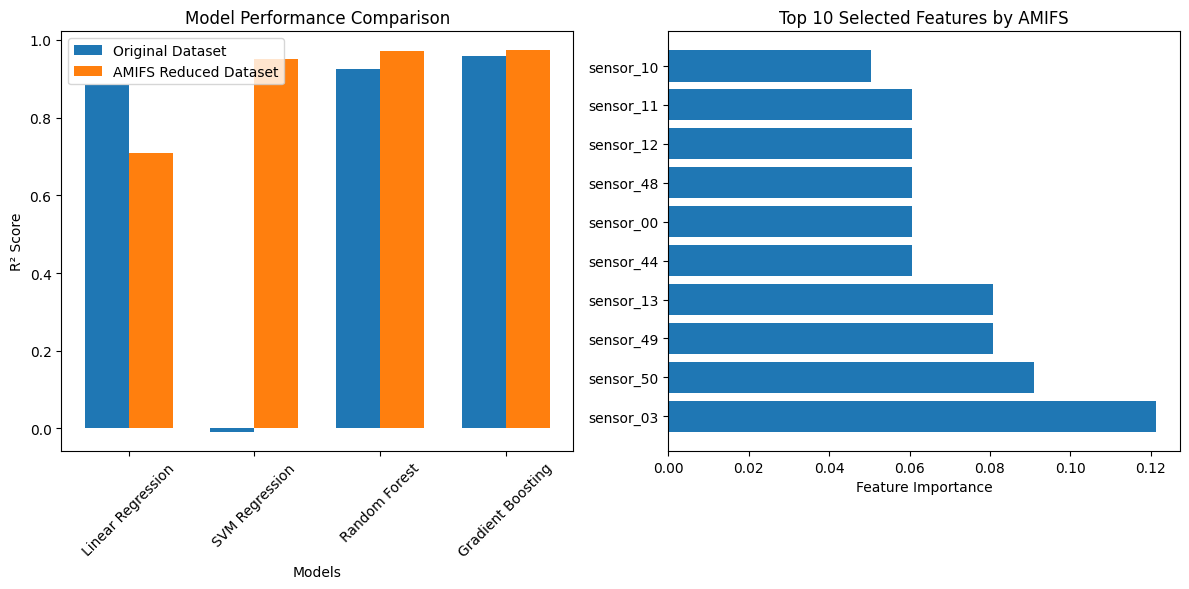


Performance Summary:
                   Original Dataset R²  AMIFS Reduced Dataset R²  \
Linear Regression             0.882988                  0.709230   
SVM Regression               -0.008762                  0.949828   
Random Forest                 0.924942                  0.971731   
Gradient Boosting             0.958570                  0.973036   

                   R² Difference  Original Training Time (s)  \
Linear Regression      -0.173758                    0.029467   
SVM Regression          0.958590                    0.003869   
Random Forest           0.046788                    0.258823   
Gradient Boosting       0.014466                    0.253088   

                   AMIFS Reduced Training Time (s)  Time Savings (%)  
Linear Regression                         0.003393         88.485687  
SVM Regression                            0.003509          9.293153  
Random Forest                             0.138302         46.565118  
Gradient Boosting               

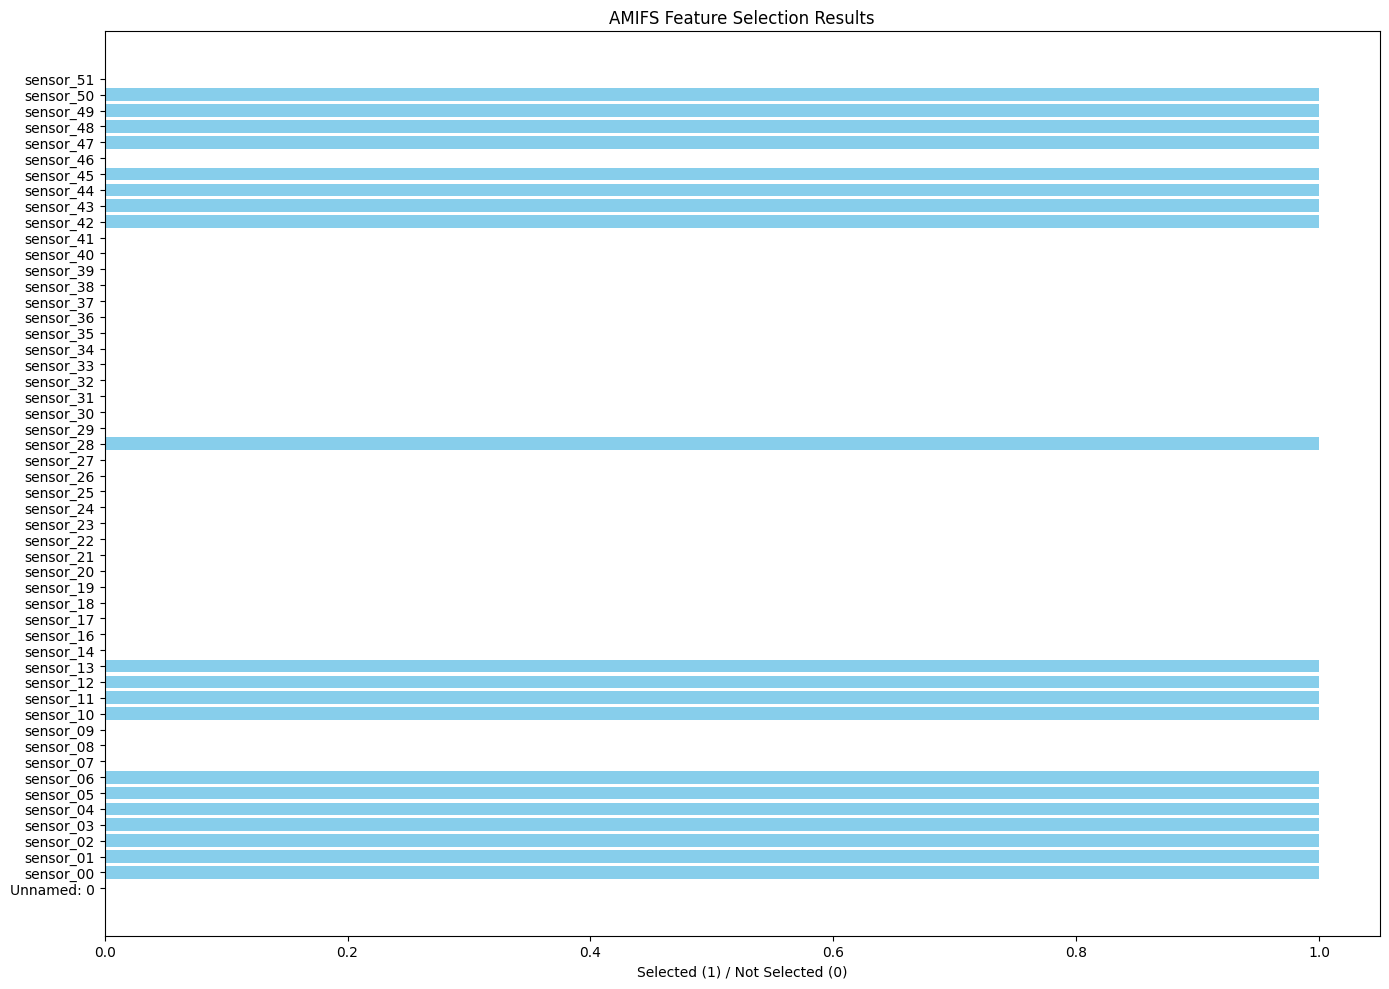

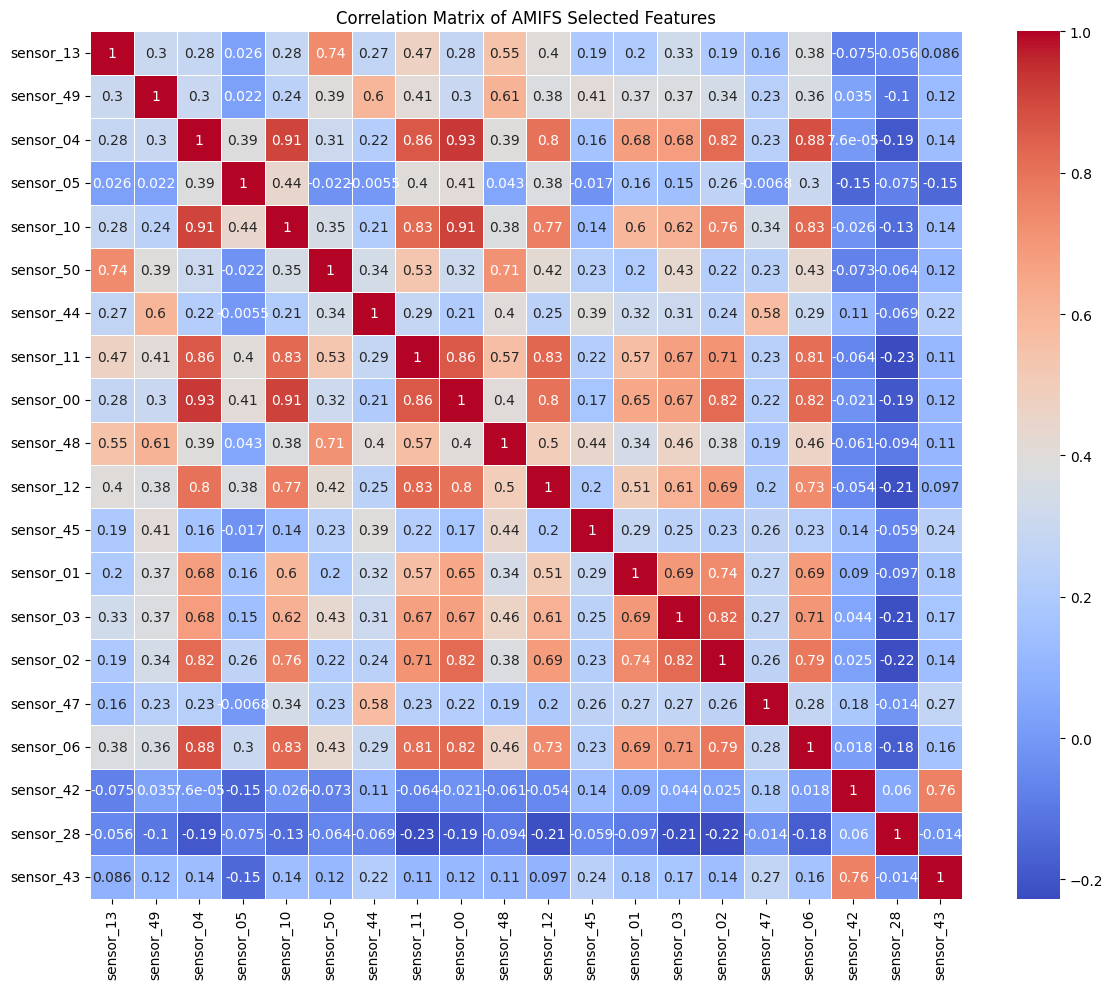

In [13]:
# 8. Display results
print("\n--- DIMENSIONALITY REDUCTION RESULTS (AMIFS) ---")
print(f"a) Features Reduced: {X_train.shape[1]} -> {len(selected_features)} ({X_train.shape[1] - len(selected_features)} features removed)")
print(f"b) AMIFS Computation Time: {amifs_time:.4f} seconds")

# Display R2 values for all models
print("\nc) R-squared Values:")
for name in models.keys():
    print(f"   {name}: Original = {original_results[name]['R2']:.4f}, Reduced (AMIFS) = {reduced_results[name]['R2']:.4f}")

# Display model accuracies (using R2 as accuracy metric for regression)
print("\nd) Model Accuracy with Original Dataset (R2):")
for name, result in original_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {original_times[name]:.4f} seconds)")

print("\ne) Model Accuracy with AMIFS Reduced Dataset (R2):")
for name, result in reduced_results.items():
    print(f"   {name}: {result['R2']:.4f} (Training time: {reduced_times[name]:.4f} seconds)")

# Create visualization for the results
plt.figure(figsize=(12, 6))

# Plot model performance comparison
models_list = list(models.keys())
original_r2 = [original_results[name]['R2'] for name in models_list]
reduced_r2 = [reduced_results[name]['R2'] for name in models_list]

x = np.arange(len(models_list))
width = 0.35

plt.subplot(1, 2, 1)
plt.bar(x - width/2, original_r2, width, label='Original Dataset')
plt.bar(x + width/2, reduced_r2, width, label='AMIFS Reduced Dataset')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models_list, rotation=45)
plt.legend()
plt.tight_layout()

# Plot AMIFS feature selection - showing top selected features importance
plt.subplot(1, 2, 2)
if len(selected_features) > 0:
    # Use Random Forest to estimate feature importance of selected features
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_amifs, y_train)

    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot feature importance
    top_n = min(10, len(selected_features))
    plt.barh(range(top_n), importances[indices[:top_n]])
    plt.yticks(range(top_n), [selected_feature_names[i] for i in indices[:top_n]])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Selected Features by AMIFS')
else:
    plt.text(0.5, 0.5, "No features selected", ha='center', va='center')

plt.tight_layout()
plt.savefig('amifs_results.png')
plt.show()

# Summary table
performance_summary = pd.DataFrame({
    'Original Dataset R²': original_r2,
    'AMIFS Reduced Dataset R²': reduced_r2,
    'R² Difference': np.array(reduced_r2) - np.array(original_r2),
    'Original Training Time (s)': [original_times[name] for name in models_list],
    'AMIFS Reduced Training Time (s)': [reduced_times[name] for name in models_list],
    'Time Savings (%)': [(1 - reduced_times[name]/original_times[name]) * 100 for name in models_list]
}, index=models_list)

print("\nPerformance Summary:")
print(performance_summary)

# Save results to CSV
performance_summary.to_csv('amifs_performance_summary.csv')

# Feature visualization for AMIFS selected features
plt.figure(figsize=(14, 10))

# Visualize the distribution of selected vs non-selected features
selected_mask = np.zeros(n_features, dtype=bool)
selected_mask[selected_features] = True

# Create a bar chart showing which features were selected
plt.barh(range(n_features), selected_mask.astype(int), color='skyblue')
plt.yticks(range(n_features), feature_names)
plt.xlabel('Selected (1) / Not Selected (0)')
plt.title('AMIFS Feature Selection Results')
plt.tight_layout()
plt.savefig('amifs_feature_selection.png')
plt.show()

# Create a correlation matrix of selected features
if len(selected_features) > 1:
    plt.figure(figsize=(12, 10))
    selected_data = X_imputed_df.iloc[:, selected_features]
    corr = selected_data.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of AMIFS Selected Features')
    plt.tight_layout()
    plt.savefig('amifs_feature_correlation.png')
    plt.show()